# Variational Auto-encoder

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data 
from tqdm import tqdm
from collections import defaultdict
from IPython.display import clear_output
import sys
sys.path.append('../python/')
%load_ext autoreload

tf.logging.set_verbosity(tf.logging.ERROR)
tf.logging.set_verbosity(tf.logging.WARN)
tf.logging.set_verbosity(tf.logging.DEBUG)
tf.logging.set_verbosity(tf.logging.FATAL)

np.random.seed(1234)
tf.set_random_seed(1234)

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
train, test = mnist.train, mnist.test

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
%autoreload
from vae import VAE, LogDerTrickVAE, MonteKarloVAE, NVILVAE, MuPropVAE
from utils import get_gradient_mean_and_std

In [4]:
n_samples = mnist.train.num_examples
n_input = 784
n_z = 20
batch_size = 128
training_epochs = 501
display_step = 25
weights_save_step = 50
save_weights = True
save_path = 'saved_weights/'

network_architecture = {
    'n_hidden_encoder_1': 80,
    'n_hidden_encoder_2': 80,
    'n_hidden_decoder_1': 80,
    'n_hidden_decoder_2': 80
}

VAE: train cost = 105.609695435, test cost = 105.329109192
LogDerTrickVAE: train cost = 141.544174194, test cost = 139.548477173
MonterKarloVAE: train cost = 117.069740295, test cost = 115.979888916
NVILVAE: train cost = 132.609970093, test cost = 132.088653564
MuPropVAE: train cost = 117.805198669, test cost = 116.914627075


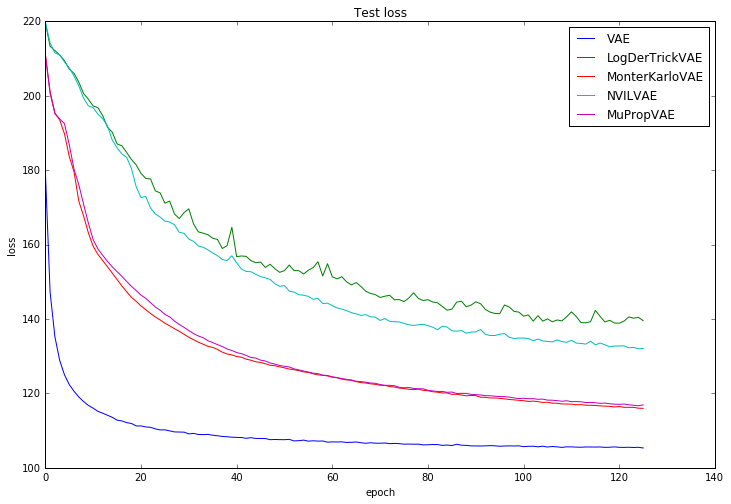

 27%|██▋       | 136/501 [3:03:27<7:57:15, 78.45s/it]

In [ ]:
vaes = [VAE, LogDerTrickVAE, MonteKarloVAE, NVILVAE, MuPropVAE]
learning_rates = [1e-3, 1e-4, 1e-4, 1e-4, 1e-4]
vaes = [vae(n_input, n_z, network_architecture, 'bernoulli', learning_rate) 
        for vae, learning_rate in zip(vaes, learning_rates)]
names = [str(vae) for vae in vaes]

test_loss = defaultdict(list)
for epoch in tqdm(range(training_epochs)):
    epoch_train_loss = defaultdict(list)
    total_batch = int(n_samples / batch_size)
    for i in range(total_batch):
        batch_xs, _ = train.next_batch(batch_size)
        for name, vae in zip(names, vaes):
            vae.partial_fit(batch_xs)
            cost = vae.loss(batch_xs)
            epoch_train_loss[name].append(cost)
    for name, vae in zip(names, vaes):
        test_loss[name].append(vae.loss(test.images))

    if epoch % display_step == 0:
        clear_output()
        for name in names:
            print('{0}: train cost = {1:.9f}, test cost = {2:.9f}'.format(name, np.mean(epoch_train_loss[name]), 
                                                                          test_loss[name][-1]), flush=True)
        plt.figure(figsize=(12, 8))
        for name in names:
            plt.plot(test_loss[name], label=name)
        plt.title('Test loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(loc='best')
        plt.show()

    if epoch % weights_save_step == 0:
        if save_weights == True:
            for name, vae in zip(names, vaes):
                vae.save_weights(save_path + name + '_{}'.format(epoch+1))
for vae in vaes:
    vae.close()

In [9]:
learning_rate = 1e-4
LDT_loss = train(LogDerTrickVAE(n_input, n_z, network_architecture, 'bernoulli', learning_rate), 
                 mnist, n_samples, batch_size, training_epochs, display_step, weights_save_step, 
                 save_weights=True, save_path = 'saved_weights/log_derivative_trick')


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch: 0001, cost = 310.891329510, test cost = 224.323501587



 10%|▉         | 50/501 [09:17<1:19:53, 10.63s/it]

Epoch: 0051, cost = 152.985317081, test cost = 151.509429932


 20%|█▉        | 100/501 [18:18<1:11:25, 10.69s/it]

Epoch: 0101, cost = 141.412178835, test cost = 140.309631348


 30%|██▉       | 150/501 [27:52<1:08:14, 11.67s/it]

Epoch: 0151, cost = 135.526955682, test cost = 135.075408936


 40%|███▉      | 200/501 [40:00<1:19:57, 15.94s/it]

Epoch: 0201, cost = 131.353606143, test cost = 130.856048584


 50%|████▉     | 250/501 [53:10<59:55, 14.32s/it]  

Epoch: 0251, cost = 130.541975977, test cost = 130.738494873


 60%|█████▉    | 300/501 [1:05:02<38:43, 11.56s/it]

Epoch: 0301, cost = 127.885843732, test cost = 127.156372070


 70%|██████▉   | 350/501 [1:14:27<27:29, 10.93s/it]

Epoch: 0351, cost = 127.207347994, test cost = 126.601562500


 80%|███████▉  | 400/501 [1:24:33<20:30, 12.18s/it]

Epoch: 0401, cost = 125.791881445, test cost = 125.218101501


 90%|████████▉ | 450/501 [1:34:25<09:30, 11.18s/it]

Epoch: 0451, cost = 125.755187180, test cost = 124.835350037


100%|█████████▉| 500/501 [1:43:58<00:11, 12.00s/it]

Epoch: 0501, cost = 124.218620827, test cost = 123.987197876


100%|██████████| 501/501 [1:44:18<00:00, 14.31s/it]


In [10]:
learning_rate = 1e-4
MK_loss = train(MonteKarloVAE(n_input, n_z, network_architecture, 'bernoulli', learning_rate), 
                mnist, n_samples, batch_size, training_epochs, display_step, weights_save_step, 
                save_weights=True, save_path = 'saved_weights/monte_karlo_trick')

  0%|          | 0/501 [00:00<?, ?it/s]

Epoch: 0001, cost = 297.503728764, test cost = 211.008697510


 10%|▉         | 50/501 [20:56<2:52:51, 23.00s/it]

Epoch: 0051, cost = 127.124264790, test cost = 126.031196594


 20%|█▉        | 100/501 [40:45<2:34:16, 23.08s/it]

Epoch: 0101, cost = 119.241677379, test cost = 118.284675598


 30%|██▉       | 150/501 [59:57<2:11:33, 22.49s/it]

Epoch: 0151, cost = 115.582902841, test cost = 114.655921936


 40%|███▉      | 200/501 [1:18:49<1:52:18, 22.39s/it]

Epoch: 0201, cost = 113.396785991, test cost = 112.658302307


 50%|████▉     | 250/501 [1:37:42<1:34:15, 22.53s/it]

Epoch: 0251, cost = 111.995962305, test cost = 111.354476929


 60%|█████▉    | 300/501 [1:56:53<1:19:30, 23.73s/it]

Epoch: 0301, cost = 111.092117472, test cost = 110.492927551


 70%|██████▉   | 350/501 [2:16:23<56:47, 22.56s/it]

Epoch: 0351, cost = 110.328356960, test cost = 109.756347656


 80%|███████▉  | 400/501 [2:35:25<37:47, 22.45s/it]

Epoch: 0401, cost = 109.700577060, test cost = 109.355346680


 90%|████████▉ | 450/501 [2:54:23<19:08, 22.52s/it]

Epoch: 0451, cost = 109.420748082, test cost = 108.846527100


100%|█████████▉| 500/501 [3:14:54<00:26, 26.86s/it]

Epoch: 0501, cost = 108.935032653, test cost = 108.542610168


100%|██████████| 501/501 [3:15:33<00:00, 30.41s/it]


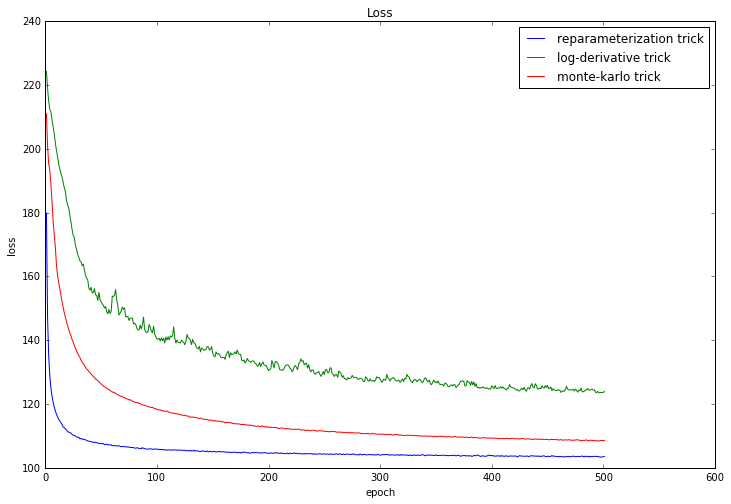

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, RT_loss.shape[0]+1), RT_loss, label='reparameterization trick')
plt.plot(np.arange(1, LDT_loss.shape[0]+1), LDT_loss, label='log-derivative trick')
plt.plot(np.arange(1, MK_loss.shape[0]+1), MK_loss, label='monte-karlo trick')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')

## Stds of gradients

In [13]:
batch_xs, _ = mnist.train.next_batch(batch_size)
n_iterations = 100

### Stds for reparameterization trick weights

In [14]:
RT_encoder_stds = []
RT_decoder_stds = []
vae = VAE(n_input, n_z, network_architecture, 'bernoulli', learning_rate)
for saved_index in tqdm(range(1, training_epochs+1, weights_save_step)):
    vae.restore_weights('saved_weights/reparameterization_trick_{}'.format(saved_index))
    _, encoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'encoder')
    _, decoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'decoder')
    RT_encoder_stds.append(encoder_std)
    RT_decoder_stds.append(decoder_std)
    
LDT_encoder_stds = []
LDT_decoder_stds = []
vae = LogDerTrickVAE(n_input, n_z, network_architecture, 'bernoulli', learning_rate)
for saved_index in tqdm(range(1, training_epochs+1, weights_save_step)):
    vae.restore_weights('saved_weights/reparameterization_trick_{}'.format(saved_index))
    _, encoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'encoder')
    _, decoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'decoder')
    LDT_encoder_stds.append(encoder_std)
    LDT_decoder_stds.append(decoder_std)
    
MK_encoder_stds = []
MK_decoder_stds = []
vae = MonteKarloVAE(n_input, n_z, network_architecture, 'bernoulli', learning_rate)
for saved_index in tqdm(range(1, training_epochs+1, weights_save_step)):
    vae.restore_weights('saved_weights/reparameterization_trick_{}'.format(saved_index))
    _, encoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'encoder')
    _, decoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'decoder')
    MK_encoder_stds.append(encoder_std)
    MK_decoder_stds.append(decoder_std)

100%|██████████| 11/11 [01:02<00:00,  5.84s/it]


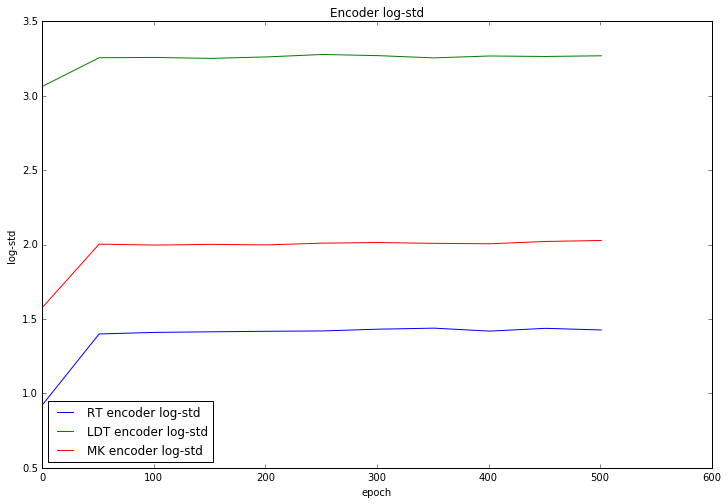

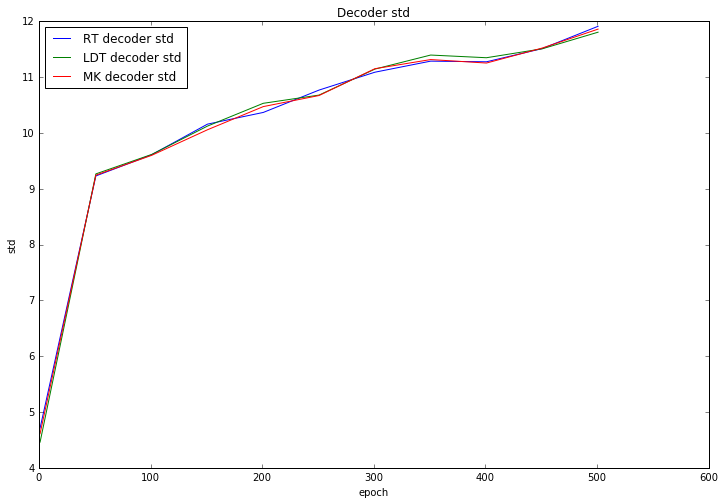

In [15]:
plt.figure(1, figsize=(12, 8))
plt.plot(np.arange(1, training_epochs+1, weights_save_step), np.log10(RT_encoder_stds), label='RT encoder log-std')
plt.plot(np.arange(1, training_epochs+1, weights_save_step), np.log10(LDT_encoder_stds), label='LDT encoder log-std')
plt.plot(np.arange(1, training_epochs+1, weights_save_step), np.log10(MK_encoder_stds), label='MK encoder log-std')
plt.title('Encoder log-std')
plt.xlabel('epoch')
plt.ylabel('log-std')
plt.legend(loc='best')
plt.show()

plt.figure(1, figsize=(12, 8))
plt.plot(np.arange(1, training_epochs+1, weights_save_step), RT_decoder_stds, label='RT decoder std')
plt.plot(np.arange(1, training_epochs+1, weights_save_step), LDT_decoder_stds, label='LDT decoder std')
plt.plot(np.arange(1, training_epochs+1, weights_save_step), MK_decoder_stds, label='MK decoder std')
plt.title('Decoder std')
plt.xlabel('epoch')
plt.ylabel('std')
plt.legend(loc='best')
plt.show()

### Stds for log-derivative trick weights

In [16]:
RT_encoder_stds = []
RT_decoder_stds = []
vae = VAE(n_input, n_z, network_architecture, 'bernoulli', learning_rate)
for saved_index in tqdm(range(1, training_epochs+1, weights_save_step)):
    vae.restore_weights('saved_weights/log_derivative_trick_{}'.format(saved_index))
    _, encoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'encoder')
    _, decoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'decoder')
    RT_encoder_stds.append(encoder_std)
    RT_decoder_stds.append(decoder_std)
    
LDT_encoder_stds = []
LDT_decoder_stds = []
vae = LogDerTrickVAE(n_input, n_z, network_architecture, 'bernoulli', learning_rate)
for saved_index in tqdm(range(1, training_epochs+1, weights_save_step)):
    vae.restore_weights('saved_weights/log_derivative_trick_{}'.format(saved_index))
    _, encoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'encoder')
    _, decoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'decoder')
    LDT_encoder_stds.append(encoder_std)
    LDT_decoder_stds.append(decoder_std)
    
MK_encoder_stds = []
MK_decoder_stds = []
vae = MonteKarloVAE(n_input, n_z, network_architecture, 'bernoulli', learning_rate)
for saved_index in tqdm(range(1, training_epochs+1, weights_save_step)):
    vae.restore_weights('saved_weights/log_derivative_trick_{}'.format(saved_index))
    _, encoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'encoder')
    _, decoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'decoder')
    MK_encoder_stds.append(encoder_std)
    MK_decoder_stds.append(decoder_std)

100%|██████████| 11/11 [00:58<00:00,  5.22s/it]


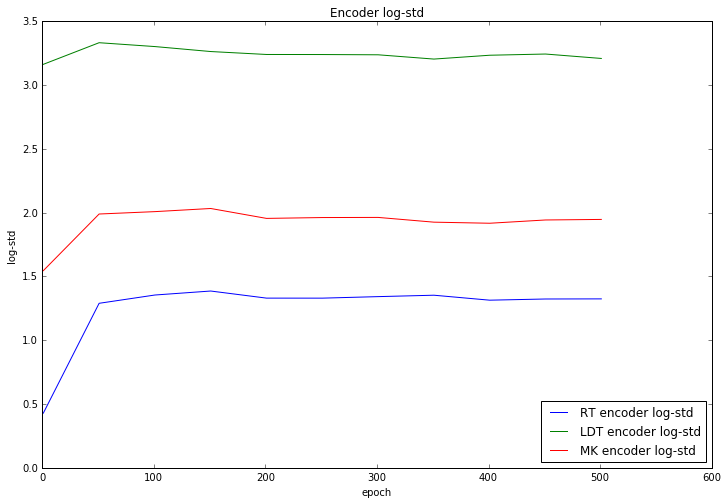

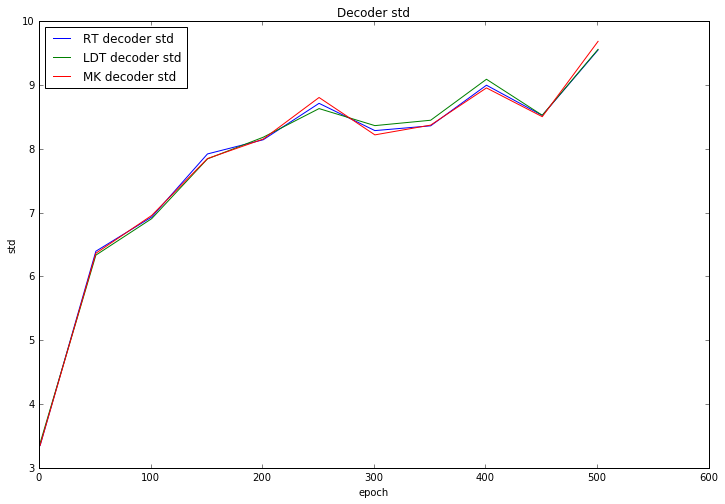

In [17]:
plt.figure(1, figsize=(12, 8))
plt.plot(np.arange(1, training_epochs+1, weights_save_step), np.log10(RT_encoder_stds), label='RT encoder log-std')
plt.plot(np.arange(1, training_epochs+1, weights_save_step), np.log10(LDT_encoder_stds), label='LDT encoder log-std')
plt.plot(np.arange(1, training_epochs+1, weights_save_step), np.log10(MK_encoder_stds), label='MK encoder log-std')
plt.title('Encoder log-std')
plt.xlabel('epoch')
plt.ylabel('log-std')
plt.legend(loc='best')
plt.show()

plt.figure(1, figsize=(12, 8))
plt.plot(np.arange(1, training_epochs+1, weights_save_step), RT_decoder_stds, label='RT decoder std')
plt.plot(np.arange(1, training_epochs+1, weights_save_step), LDT_decoder_stds, label='LDT decoder std')
plt.plot(np.arange(1, training_epochs+1, weights_save_step), MK_decoder_stds, label='MK decoder std')
plt.title('Decoder std')
plt.xlabel('epoch')
plt.ylabel('std')
plt.legend(loc='best')
plt.show()

### Stds for Monte-Karlo trick weights

In [18]:
RT_encoder_stds = []
RT_decoder_stds = []
vae = VAE(n_input, n_z, network_architecture, 'bernoulli', learning_rate)
for saved_index in tqdm(range(1, training_epochs+1, weights_save_step)):
    vae.restore_weights('saved_weights/monte_karlo_trick_{}'.format(saved_index))
    _, encoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'encoder')
    _, decoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'decoder')
    RT_encoder_stds.append(encoder_std)
    RT_decoder_stds.append(decoder_std)
    
LDT_encoder_stds = []
LDT_decoder_stds = []
vae = LogDerTrickVAE(n_input, n_z, network_architecture, 'bernoulli', learning_rate)
for saved_index in tqdm(range(1, training_epochs+1, weights_save_step)):
    vae.restore_weights('saved_weights/monte_karlo_trick_{}'.format(saved_index))
    _, encoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'encoder')
    _, decoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'decoder')
    LDT_encoder_stds.append(encoder_std)
    LDT_decoder_stds.append(decoder_std)
    
MK_encoder_stds = []
MK_decoder_stds = []
vae = MonteKarloVAE(n_input, n_z, network_architecture, 'bernoulli', learning_rate)
for saved_index in tqdm(range(1, training_epochs+1, weights_save_step)):
    vae.restore_weights('saved_weights/monte_karlo_trick_{}'.format(saved_index))
    _, encoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'encoder')
    _, decoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'decoder')
    MK_encoder_stds.append(encoder_std)
    MK_decoder_stds.append(decoder_std)

100%|██████████| 11/11 [01:17<00:00,  9.49s/it]


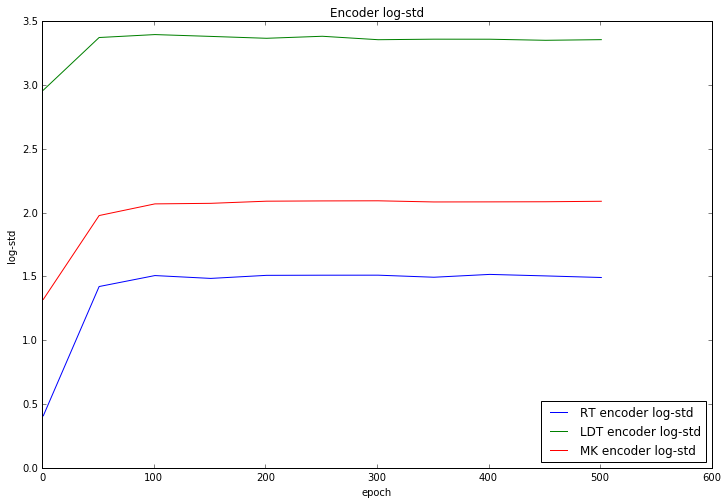

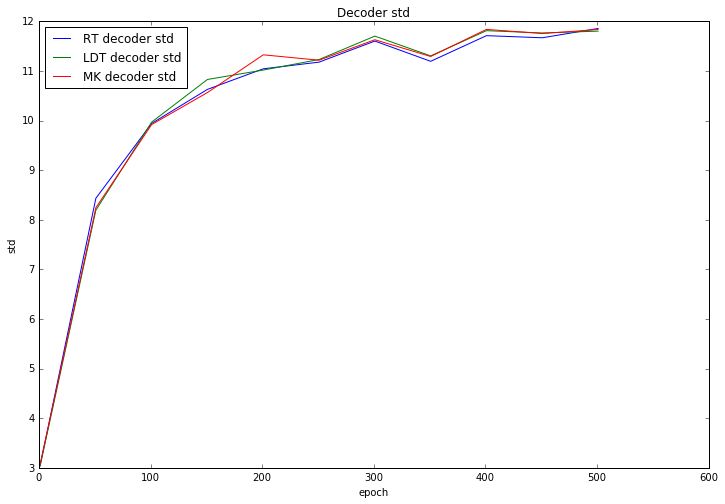

In [19]:
plt.figure(1, figsize=(12, 8))
plt.plot(np.arange(1, training_epochs+1, weights_save_step), np.log10(RT_encoder_stds), label='RT encoder log-std')
plt.plot(np.arange(1, training_epochs+1, weights_save_step), np.log10(LDT_encoder_stds), label='LDT encoder log-std')
plt.plot(np.arange(1, training_epochs+1, weights_save_step), np.log10(MK_encoder_stds), label='MK encoder log-std')
plt.title('Encoder log-std')
plt.xlabel('epoch')
plt.ylabel('log-std')
plt.legend(loc='best')
plt.show()

plt.figure(1, figsize=(12, 8))
plt.plot(np.arange(1, training_epochs+1, weights_save_step), RT_decoder_stds, label='RT decoder std')
plt.plot(np.arange(1, training_epochs+1, weights_save_step), LDT_decoder_stds, label='LDT decoder std')
plt.plot(np.arange(1, training_epochs+1, weights_save_step), MK_decoder_stds, label='MK decoder std')
plt.title('Decoder std')
plt.xlabel('epoch')
plt.ylabel('std')
plt.legend(loc='best')
plt.show()

## Difference between the means of gradients. Reparameterization trick weights

In [20]:
min_iterations = 1000
max_iterations = 10001
step = 1000
weights_save_step = 250

## Encoder gradients

In [22]:
ldt_encoder_gradients_delta = {}
mk_encoder_gradients_delta = {}
rt_vae = VAE(n_input, n_z, network_architecture, 'bernoulli', learning_rate)
ldt_vae = LogDerTrickVAE(n_input, n_z, network_architecture, 'bernoulli', learning_rate)
mk_vae = MonteKarloVAE(n_input, n_z, network_architecture, 'bernoulli', learning_rate)
for saved_index in tqdm(range(1, training_epochs+1, weights_save_step)):
    ldt_encoder_gradients_delta['epoch_{}'.format(saved_index)] = []
    mk_encoder_gradients_delta['epoch_{}'.format(saved_index)] = []
    rt_vae.restore_weights('saved_weights/reparameterization_trick_{}'.format(saved_index))
    ldt_vae.restore_weights('saved_weights/reparameterization_trick_{}'.format(saved_index))
    mk_vae.restore_weights('saved_weights/reparameterization_trick_{}'.format(saved_index))
    for n_iterations in tqdm(range(min_iterations, max_iterations, step)):
        rt_mean, _ = get_gradient_mean_and_std(rt_vae, batch_xs, n_iterations, 'encoder')
        ldt_mean, _ = get_gradient_mean_and_std(ldt_vae, batch_xs, n_iterations, 'encoder')
        mk_mean, _ = get_gradient_mean_and_std(mk_vae, batch_xs, n_iterations, 'encoder')
        ldt_encoder_gradients_delta['epoch_{}'.format(saved_index)].append(np.linalg.norm(rt_mean - ldt_mean))
        mk_encoder_gradients_delta['epoch_{}'.format(saved_index)].append(np.linalg.norm(rt_mean - mk_mean))
    print('epoch_{}'.format(saved_index))

100%|██████████| 10/10 [1:54:05<00:00, 1054.71s/it]

epoch_1
epoch_251


100%|██████████| 10/10 [2:03:26<00:00, 1162.11s/it]


epoch_501


100%|██████████| 3/3 [6:13:54<00:00, 7668.94s/it]  

### Difference between reparameterization trick and log-derivative trick

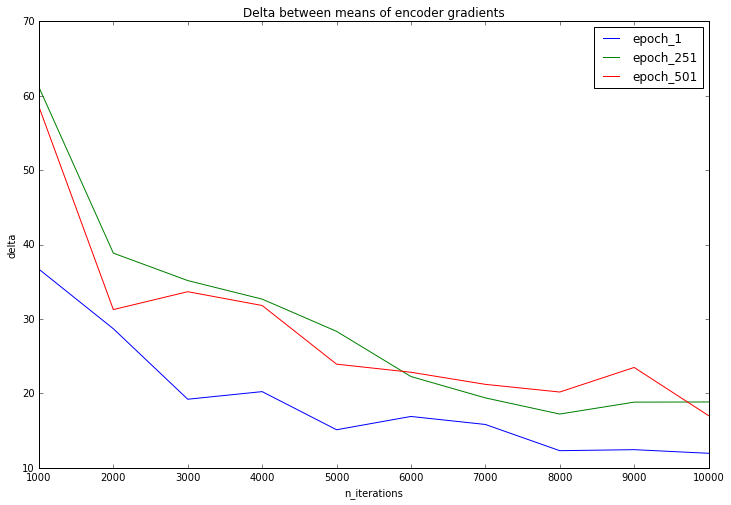

In [23]:
plt.figure(figsize=(12, 8))
for saved_index in range(1, training_epochs+1, weights_save_step):
    plt.plot(np.arange(min_iterations, max_iterations, step), 
             ldt_encoder_gradients_delta['epoch_{}'.format(saved_index)], label='epoch_{}'.format(saved_index))
plt.title('Delta between means of encoder gradients')
plt.xlabel('n_iterations')
plt.ylabel('delta')
plt.legend(loc='best')

### Difference between reparameterization trick and Monte-Karlo trick

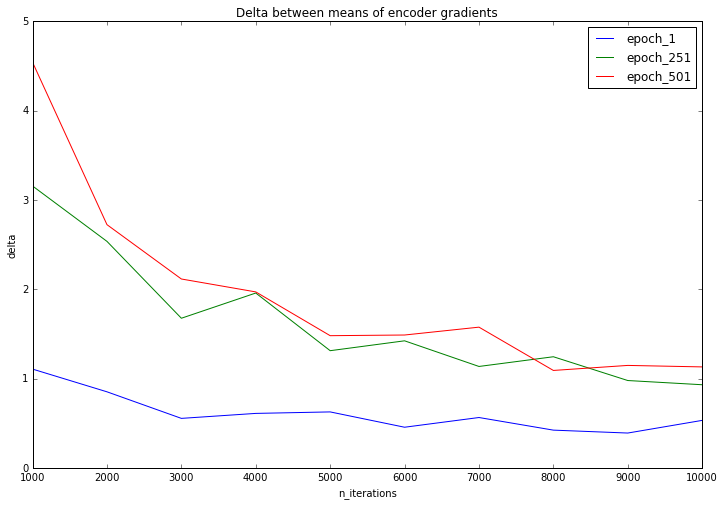

In [24]:
plt.figure(figsize=(12, 8))
for saved_index in range(1, training_epochs+1, weights_save_step):
    plt.plot(np.arange(min_iterations, max_iterations, step), 
             mk_encoder_gradients_delta['epoch_{}'.format(saved_index)], label='epoch_{}'.format(saved_index))
plt.title('Delta between means of encoder gradients')
plt.xlabel('n_iterations')
plt.ylabel('delta')
plt.legend(loc='best')

## Decoder gradients

In [25]:
ldt_decoder_gradients_delta = {}
mk_decoder_gradients_delta = {}
rt_vae = VAE(n_input, n_z, network_architecture, 'bernoulli', learning_rate)
ldt_vae = LogDerTrickVAE(n_input, n_z, network_architecture, 'bernoulli', learning_rate)
mk_vae = MonteKarloVAE(n_input, n_z, network_architecture, 'bernoulli', learning_rate)
for saved_index in tqdm(range(1, training_epochs+1, weights_save_step)):
    ldt_decoder_gradients_delta['epoch_{}'.format(saved_index)] = []
    mk_decoder_gradients_delta['epoch_{}'.format(saved_index)] = []
    rt_vae.restore_weights('saved_weights/reparameterization_trick_{}'.format(saved_index))
    ldt_vae.restore_weights('saved_weights/reparameterization_trick_{}'.format(saved_index))
    mk_vae.restore_weights('saved_weights/reparameterization_trick_{}'.format(saved_index))
    for n_iterations in tqdm(range(min_iterations, max_iterations, step)):
        rt_mean, _ = get_gradient_mean_and_std(rt_vae, batch_xs, n_iterations, 'decoder')
        ldt_mean, _ = get_gradient_mean_and_std(ldt_vae, batch_xs, n_iterations, 'decoder')
        mk_mean, _ = get_gradient_mean_and_std(mk_vae, batch_xs, n_iterations, 'decoder')
        ldt_decoder_gradients_delta['epoch_{}'.format(saved_index)].append(np.linalg.norm(rt_mean - ldt_mean))
        mk_decoder_gradients_delta['epoch_{}'.format(saved_index)].append(np.linalg.norm(rt_mean - mk_mean))
    print('epoch_{}'.format(saved_index))

100%|██████████| 10/10 [1:47:02<00:00, 1004.65s/it]

epoch_1
epoch_251


100%|██████████| 10/10 [1:52:04<00:00, 1033.64s/it]


epoch_501


100%|██████████| 3/3 [5:31:38<00:00, 6674.02s/it]  

### Difference between reparameterization trick and log-derivative trick

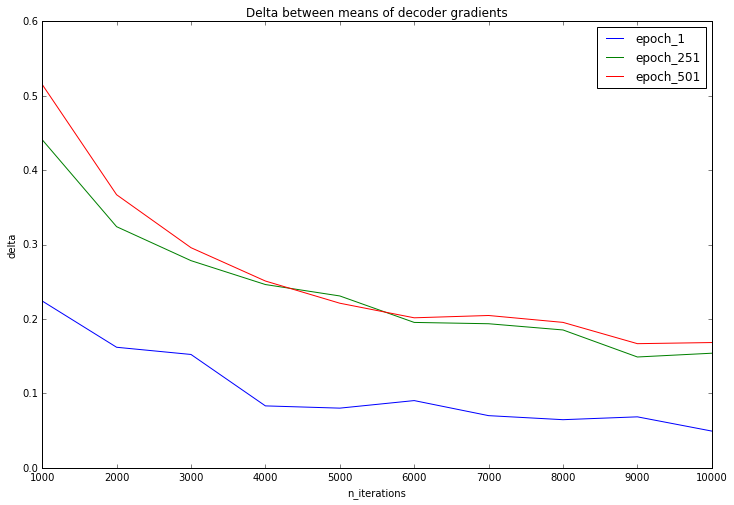

In [26]:
plt.figure(figsize=(12, 8))
for saved_index in range(1, training_epochs+1, weights_save_step):
    plt.plot(np.arange(min_iterations, max_iterations, step), 
             ldt_decoder_gradients_delta['epoch_{}'.format(saved_index)], label='epoch_{}'.format(saved_index))
plt.title('Delta between means of decoder gradients')
plt.xlabel('n_iterations')
plt.ylabel('delta')
plt.legend(loc='best')

### Difference between reparameterization trick and Monte-Karlo trick

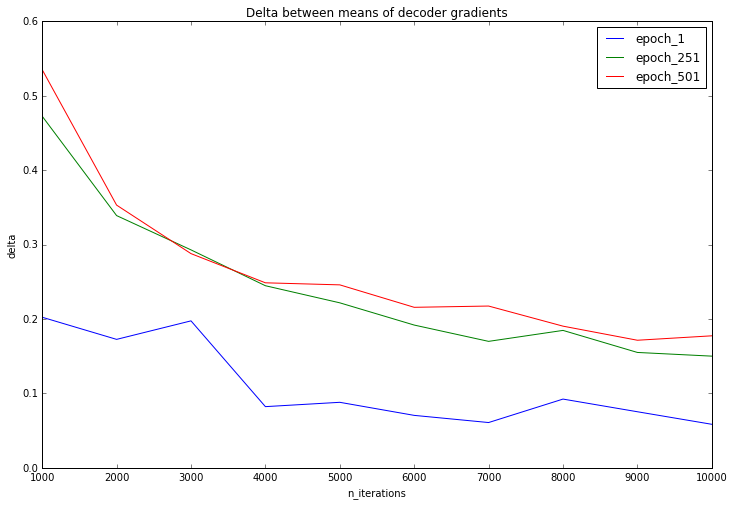

In [27]:
plt.figure(figsize=(12, 8))
for saved_index in range(1, training_epochs+1, weights_save_step):
    plt.plot(np.arange(min_iterations, max_iterations, step), 
             mk_decoder_gradients_delta['epoch_{}'.format(saved_index)], label='epoch_{}'.format(saved_index))
plt.title('Delta between means of decoder gradients')
plt.xlabel('n_iterations')
plt.ylabel('delta')
plt.legend(loc='best')